### Model of transmission between towns

Given a series of heterogeneous communties of different sizes within different districts, build a contact model for movement between them. Movement simulation not implemented

This is a prototype - only infers movement pattern based on the size of different locations and whether or not the two towns are in the same district. 

# This version is not practical


Preamble, load relvant packages

In [1]:
using LightGraphs, Plots, GraphPlot, Compose, Random

In [2]:
include("ContactModels.jl")

rewire! (generic function with 1 method)

In [3]:
include("EpiSim.jl")

Main.EpiSim

In [4]:
net=covidsafe(limitmix(100^2,50),0.4)

{10000, 17178} undirected simple Int64 graph

## Extract the largest connecte component of a graph

In [5]:
function getbiggestbit(net)
    #dentify the vertices in the largest connected component of net
    cc=connected_components(net)
    bigi=0
    bign=0
    for i in 1:length(cc)
        if length(cc[i])>bign 
            bign=length(cc[i])
            bigi=i
        end
    end
    return cc[bigi]
end

getbiggestbit (generic function with 1 method)

In [6]:
net=net[getbiggestbit(net)]
ndsz=[length(neighbors(net,vert)) for vert in vertices(net)]
gplot(net, nodefillc=colorant"red",nodesize=ndsz,NODESIZE=0.10)

In [7]:
#'reasonable' parameters
epiparam=Dict()
epiparam["p0"]=1/10 #a guess - tuned to match observed data 
epiparam["q"]=1/8 #"up to" two weeks
epiparam["r0"]=1/4 #about two weeks for mild, 3-6 for severe
epiparam["nseeds"]=5 #probably too many, consider dropping.
#parameters don't change across transition point - assume about 5 undiagnosed case 
#and control the covidsafe uptake via network structure
i=8
epiparam["pop"]=100^2
#epiparam["gridsize"]=100

10000

In [8]:
netmodel=net
ndays=200
nsims=100
St,Et,It,Rt=EpiSim.episim(netmodel, epiparam, ndays, nsims)  

100.0%┣███████████████████████████████████████┫ 100/100 [00:06<00:00, 16.7 it/s]


(UInt64[0x000000000000270b 0x000000000000270b … 0x000000000000270b 0x000000000000270b; 0x000000000000270b 0x000000000000270b … 0x000000000000270b 0x000000000000270b; … ; 0x0000000000001aff 0x0000000000001a1b … 0x0000000000002704 0x0000000000001adf; 0x0000000000001afa 0x0000000000001a19 … 0x0000000000002704 0x0000000000001adc], UInt64[0x0000000000000004 0x0000000000000005 … 0x0000000000000004 0x0000000000000005; 0x0000000000000001 0x0000000000000004 … 0x0000000000000004 0x0000000000000004; … ; 0x0000000000000038 0x0000000000000019 … 0x0000000000000000 0x000000000000005a; 0x0000000000000030 0x0000000000000015 … 0x0000000000000000 0x0000000000000051], UInt64[0x0000000000000001 0x0000000000000000 … 0x0000000000000001 0x0000000000000000; 0x0000000000000004 0x0000000000000001 … 0x0000000000000000 0x0000000000000001; … ; 0x0000000000000022 0x000000000000000a … 0x0000000000000000 0x000000000000002f; 0x0000000000000026 0x000000000000000c … 0x0000000000000000 0x0000000000000030], UInt64[0x000000

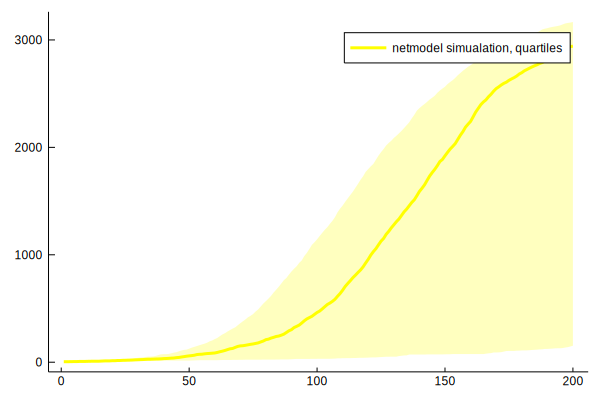

In [9]:
EpiSim.plotquantiles(epiparam["pop"] .- St,:yellow,"netmodel simualation, quartiles",0.25)

In [10]:
using CSV

In [11]:
wapop=CSV.read("WA-pop.csv")

56×3 DataFrames.DataFrame
│ Row │ Column1            │ Column2   │ Column3              │
│     │ String             │ String    │ String               │
├─────┼────────────────────┼───────────┼──────────────────────┤
│ 1   │ Perth              │ 1,874,578 │ Perth                │
│ 2   │ Bunbury            │ 71,090    │ South West           │
│ 3   │ Geraldton          │ 31,982    │ Mid West             │
│ 4   │ Kalgoorlie-Boulder │ 29,875    │ Goldfields-Esperance │
│ 5   │ Albany             │ 29,373    │ Great Southern       │
│ 6   │ Busselton          │ 25,329    │ South West           │
│ 7   │ Karratha           │ 15,828    │ Pilbara              │
│ 8   │ Broome             │ 13,984    │ Kimberley            │
│ 9   │ Port Hedland       │ 13,828    │ Pilbara              │
│ 10  │ Esperance          │ 10,421    │ Goldfields-Esperance │
⋮
│ 46  │ Jurien Bay         │ 1,425     │ Wheatbelt            │
│ 47  │ Paraburdoo         │ 1,359     │ Pilbara              │
│ 48  │ Wagin              │ 1,358     │ Wheatbelt            │
│ 49  │ Kalbarri           │ 1,349     │ Mid West             │
│ 50  │ Serpentine         │ 1,265     │ Peel                 │
│ 51  │ Binningup          │ 1,227     │ South West           │
│ 52  │ Kojonup            │ 1,165     │ Great Southern       │
│ 53  │ Boddington-Ranford │ 1,147     │ Peel                 │
│ 54  │ Fitzroy Crossing   │ 1,141     │ Kimberley            │
│ 55  │ Augusta            │ 1,109     │ South West           │
│ 56  │ Dampier            │ 1,104     │ Pilbara              │

In [12]:
wapopint=parse.(Int, replace.(wapop[:,2], r","=> ""))

56-element Array{Int64,1}:
 1874578
   71090
   31982
   29875
   29373
   25329
   15828
   13984
   13828
   10421
    8859
    7192
    6548
       ⋮
    1448
    1425
    1359
    1358
    1349
    1265
    1227
    1165
    1147
    1141
    1109
    1104

## This is the meat of the code - build a network for movement in a community

Given the CSV list of (Town, Population, District) build a state-level network of connection patterns/movement within the community. Connectivity between locales is (here) only inferred based on populations

In [ ]:
function buildstate(statedata, netbuilder, withindistrictbonus=5)
    # buildstate(statedata, netbuilder, withindistrictbonus=5)
    ##############################################################################
    #statedata is a csv table loaded from the structure /format above - three columns (town, population, district)
    #netbuilder is the intra-locale network construction rule (a function)
    #withindistrictbonus is the multiplicative bonus to the number of edges for travel between locales in the same district.
    ##############################################################################
    #
    #extract the data from CSV table
    locale=statedata[:,1]
    popl=parse.(Int, replace.(statedata[:,2], r","=> ""))
    distrc=statedata[:,3]
    npl=length(popl)
    #
    ##############################################################################
 ##    nppl=1000 # assume 1 in 1000 people moving, on average
    ##############################################################################
    #
    net=SimpleGraph() #empty graph
    transit=Array{Int64,2}(undef,npl,npl) #number of transits beween locale[i] and locale[j]
    for (i,town) in enumerate(locale)
        println("Adding ",town," (population: ",popl[i],")")
        #add the intralocale links
        netadd=netbuilder(popl[i]) #use the preassigned method to add the new component
        net=blockdiag(net,netadd)
        #compute the amount of transit
        for j in 1:(i-1) #number of transit between here and every other previous part
        transit[i,j] = Int(ceil(sqrt(popl[i]*popl[j])/nppl)) #number of trips proportional to geometric mean of populations
            if distrc[i]==distrc[j]
                transit[i,j]=transit[i,j]*withindistrictbonus #5 time higher if within the same district
            end
            transit[j,i]=transit[i,j]
        end
        transit[i,i]=0
    end
    #
    #add the inter-locale links too --- could do it in the same (previous) loops, but this is clearer (I think)
    #
    rr=[0; cumsum(popl)]
    nedges_add = 0
    for i in 1:npl
        for j in (i+1):npl
            #
            edg1=rand(collect(rr[i]+1:rr[i+1]),transit[i,j])
            edg2=rand(collect(rr[j]+1:rr[j+1]),transit[i,j])
            for k in 1:transit[i,j]
                add_edge!(net,edg1[k],edg2[k]) #this is grossly inefficient - but only needs to be done once.
                nedges_add + 1              #simple count, keep track of how many new edges came in here
            end
            #
        end
    end
    #all done
    return net, transit, locale, popl, distrc, nedges_add
end

In [14]:
net, transit, locale, popl, distrc = buildstate(wapop[3:end,:], x -> covidsafe(nomassmix(x),0.5))

Adding Geraldton (population: 31982)
Adding Kalgoorlie-Boulder (population: 29875)


UndefVarError: UndefVarError: nppl not defined

In [15]:
#This could take a while - but it might be pretty.
# gplot(net)

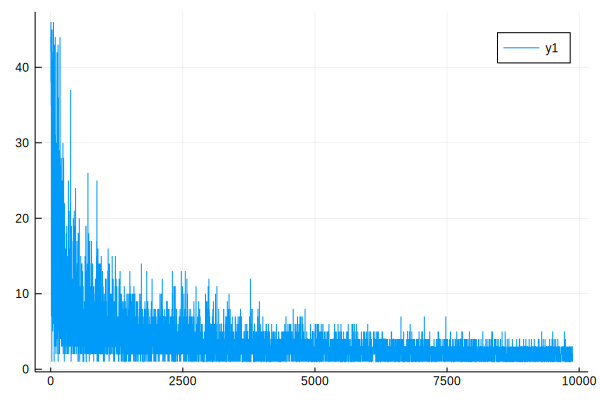

In [16]:
plot(degree(net))

In [17]:
net

{9875, 17176} undirected simple Int64 graph

In [18]:
g = blockdiag(star_graph(5),path_graph(4))

{9, 7} undirected simple Int64 graph

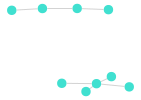

In [19]:
gplot(g)

In [20]:
g = [star_graph(5) path_graph(4)]

1×2 Array{SimpleGraph{Int64},2}:
 {5, 4} undirected simple Int64 graph  {4, 3} undirected simple Int64 graph

## Michael Small 11/6/20